In [ ]:
!pip install pytorch-crf

In [ ]:
import random
import numpy as np
import pandas as pd
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
from torchcrf import CRF
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from typing import Union, List, Tuple

# DATA PREPROCESSING

In [ ]:
train_sents= []
f = open("/content/wnut17train.conll")
sent = []
for l in f.readlines():
  sent.append(tuple(l.strip().split("\t")))
  if len(l.strip()) == 0 :
    train_sents.append(sent)
    sent = []
  

for sent in train_sents:
  del sent[-1]


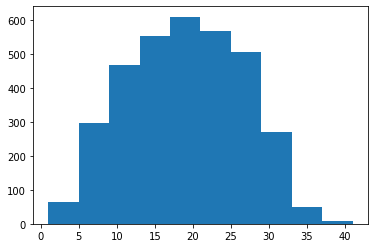

In [ ]:
sen_lens = [len(sentence) for sentence in train_sents]
plt.hist(sen_lens)
plt.show()

In [ ]:
def prepare_vocabulary_tags(
    train_sents: List[List[Tuple[str, str]]],
    unknown_percent:int = None):
  
    tags = set()
    for sentence in train_sents:
        for line in sentence:
            tags.add(line[1])
    tags = sorted(tags, key=len)
    tag_to_ix = {tag:i for i,tag in enumerate(tags)}

    word_to_ix = {}
    word_to_ix['<UNK>'] = 0
    word_to_ix['<PAD>'] = 1

    # For each words-list (sentence) and tags-list in each tuple of training_data
    for sentence in train_sents:
        for line in sentence:
            if line[0] not in word_to_ix:  # word has not been assigned an index yet
                word_to_ix[line[0]] = len(word_to_ix)  # Assign each word with a unique index

    if unknown_percent:
        print("Using randomized unkown tokens")

        num_total_words = len(word_to_ix) - 2  # not considering pad and unk token
        num_unknown_words = round(num_total_words*unknown_percent)

        unknown_indices = np.random.randint(low = 2, high=len(word_to_ix)-1, size = num_unknown_words)
        all_keys = list(word_to_ix.keys())

        all_keys.remove('<PAD>')
        all_keys.remove('<UNK>')
        random_keys = random.sample(all_keys, num_unknown_words)

        for word in random_keys:
            word_to_ix[word] = 0 # <UNK> index

    return tag_to_ix, word_to_ix

In [ ]:
tag_to_ix, word_to_ix = prepare_vocabulary_tags(train_sents, 0.05)

In [ ]:
tag_to_ix

{'B-corporation': 10,
 'B-creative-work': 12,
 'B-group': 2,
 'B-location': 7,
 'B-person': 3,
 'B-product': 6,
 'I-corporation': 9,
 'I-creative-work': 11,
 'I-group': 1,
 'I-location': 8,
 'I-person': 4,
 'I-product': 5,
 'O': 0}

In [ ]:
class NerDataset(Dataset):
    def __init__(self, file_path, transform = None):
        self.file_path = file_path
        self.transform = transform
        # self.train_sents = self.read_data()
        self.X, self.y = self.read_data()
        self.n_samples = len(self.X)
        self.add_padding()
        
    def __getitem__(self, idx):
        sample = self.X[idx], self.y[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def __len__(self):
        return self.n_samples

    def read_data(self):
        X = []
        y = []
        f = open(self.file_path)
        tokens = []
        tags = []
        for l in f.readlines():
          if len(l.strip()) == 0 :
            X.append(tokens)
            y.append(tags)
            tokens = []
            tags = []
          else:
            token, tag = l.strip().split("\t")
            if token in word_to_ix:
                tokens.append(word_to_ix[token])
            else:
                tokens.append(0) # index for <UNK> 
            tags.append(tag_to_ix[tag])
        
        return X, y

    def add_padding(self):
        max_length = max([len(s) for s in self.X])
        for sentence in self.X:
           while len(sentence) <= max_length:
               sentence.append(1) # pad index is 1 in word_to_ix
        for tags in self.y:
            while len(tags) <= max_length:
                tags.append(len(tag_to_ix))

class customToTensor:
  def __call__(self, sample):
    inputs, labels = sample

    return torch.from_numpy(np.array(inputs)), torch.from_numpy(np.array(labels))

In [ ]:
dataset = NerDataset(file_path="/content/wnut17train.conll", transform= customToTensor())

In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size=4)

In [ ]:
first_data = dataset[0]
features,labels = first_data
# print(first_data)
print(features)
print(labels)

tensor([ 2,  3,  4,  5,  6,  0,  0,  9, 10, 11, 12, 13, 14, 15, 16,  0, 18, 19,
        20, 15, 21, 22, 23, 24, 25, 26, 15,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  8,  8,  0,
         7,  0,  0,  0,  0,  0,  0,  0,  0, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13])


In [ ]:
dataiter = iter(dataloader)
data = dataiter.next()
features, labels = data
print(features.size(), labels.size())
print(features)
print(labels)

torch.Size([4, 42]) torch.Size([4, 42])
tensor([[ 2,  3,  4,  5,  6,  0,  0,  9, 10, 11, 12, 13, 14, 15, 16,  0, 18, 19,
         20, 15, 21, 22, 23, 24, 25, 26, 15,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1],
        [27, 28, 29, 30, 31, 32, 33, 12, 34, 35, 36, 37, 15, 38, 39,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1],
        [40, 41,  0, 43, 44, 45, 46, 47, 48, 49, 50, 51,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1],
        [52, 53, 54, 25, 55, 56,  5, 57, 15,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  8,  8,  0,
          7,  0,  0,  0,  0,  0,  0,  0,  0, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 

# MODEL

In [ ]:
EMBEDDING_DIM = 50 #input size
HIDDEN_DIM = 32
BATCH_SIZE = 15
NUM_ENTITIES = len(tag_to_ix) + 1 # to account for pad tag
VOCAB_SIZE = len(word_to_ix)
NUM_EPOCHS = 50

In [ ]:
class NER_Model(nn.Module):
  """Named Entity Recognition
  """

  def __init__(self, 
              input_size: int, 
              hidden_size: int, 
              num_classes: int,
              vocab_size: int,
              num_layers: int,
              bi_directional:bool,
              use_crf:bool = False):
      """
      Parameters:
        input_size: embedding dimensions
        hidden_size: hidden layer dimension
        num_classes: number of entities/classes
        vocab_size: number of words in training data
        num_layers: number of latm layers
        bi_directional: BiLSTM if True else LSTM
        use_crf: CRF layer if True else NLL loss
      """
      super(NER_Model, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.num_classes = num_classes
      self.vocab_size = vocab_size
      self.num_layers = num_layers
      self.use_crf = use_crf
      self.bi_directional = bi_directional

      self.word_embeddings = nn.Embedding(vocab_size, input_size)

      if self.bi_directional:
          self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                              bidirectional = self.bi_directional, batch_first = True)
          self.linear = nn.Linear(in_features = 2*hidden_size, out_features= num_classes) 
      else:
          self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
          self.linear = nn.Linear(in_features = hidden_size, out_features= num_classes) 
      
      self.logsoftmax = nn.LogSoftmax(dim=2)

      self.crf = CRF(self.num_classes, batch_first=True)

  def forward(self, x):
      """
      Parameters:
          x: input (batch_size, seq_len, input_dim)
      """
      x = self.word_embeddings(x)

      batch_size = x.size()[0]

      h0, c0 = self.init_hidden(batch_size)

      # output = (batch_size, seq_len, hidden_size)
      output, (hn, cn) = self.lstm(x, (h0,c0))

      # output = (batch_size, seq_len, num_classes)
      output = self.linear(output)

      if self.use_crf:
          return output
      else:    
          # output = (batch_size, seq_len, num_classes)
          output = self.logsoftmax(output)

      return output

  def init_hidden(self, batch_size: int):
      """Initialize hidden state
      
      Parameters:
          batch_size: input batch size

      Returns:
          Tuple of initial hidden_state and cell_state filled with zeroes
      """

      if self.bi_directional:
          D = 2
      else:
          D = 1 
      h0 = torch.zeros(D*self.num_layers, batch_size, self.hidden_size)
      c0 = torch.zeros(D*self.num_layers, batch_size, self.hidden_size)

      return h0, c0

def calculate_metrics(dataloader: DataLoader):
    true_labels = []
    pred_labels = []

    with torch.no_grad():
      n_correct = 0
      n_samples = 0
      for input, label in dataloader:

        # output (batch_size, seq_len, num_classes), label = (batch_size, seq_len, 1)
        output = ner(input)

        if ner.use_crf:
            predictions = torch.tensor(ner.crf.decode(output))
            predictions = predictions.view(-1)

        else:
        # output (batch_size, seq_len, num_classes) -> (batch_size * seq_len, num_classes)
            output = output.view(-1, NUM_ENTITIES)
            # predictions = (batch_size * seq_len)
            _, predictions = torch.max(output, 1)

        # label (batch_size, seq_len, 1) -> (batch_size * seq_len)
        label = label.view(-1)

        true_labels += label
        pred_labels += predictions

    true_labels = [l.item() for l in true_labels]
    pred_labels = [l.item() for l in pred_labels]

    if ner.use_crf:
        print("Using CRF")
        
    print(classification_report(y_true= true_labels, y_pred= pred_labels))

In [ ]:
ner = NER_Model(input_size= EMBEDDING_DIM, hidden_size= HIDDEN_DIM, num_classes= NUM_ENTITIES, 
                vocab_size=VOCAB_SIZE, num_layers=1, bi_directional = True, use_crf = True)
optimizer = optim.Adam(ner.parameters(), lr=0.01, weight_decay=1e-4)
# optimizer = optim.SGD(ner.parameters(), lr = 0.005)
criterion = nn.NLLLoss(ignore_index=13)

In [ ]:
train_dataset = NerDataset(file_path="/content/wnut17train.conll", transform= customToTensor())
train_dataloader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE)

val_dataset = NerDataset(file_path="/content/emerging.dev.conll", transform= customToTensor())
val_dataloader = DataLoader(dataset = val_dataset, batch_size=BATCH_SIZE)

In [ ]:
metric = {'epoch': [], 'train_loss': [], 'val_loss': []}
loss_metric = []
t = tqdm(range(NUM_EPOCHS), leave=False, position=0)
for epoch in t:
  batch_train_loss = []
  for input, label in train_dataloader:
    
    optimizer.zero_grad()

    # output (batch_size, seq_len, num_classes), label = (batch_size, seq_len, 1)
    output = ner(input)

    if ner.use_crf:

        loss = -ner.crf(output, label) #mask

    else:
        # label (batch_size, seq_len, 1) -> (batch_size * seq_len)
        label = label.view(-1)
        # output (batch_size, seq_len, num_classes) -> (batch_size * seq_len, num_classes)
        output = output.view(-1, NUM_ENTITIES)
        loss = criterion(output, label)

    batch_train_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  epoch_train_loss  = sum(batch_train_loss)/ len(batch_train_loss)
  metric['train_loss'].append(epoch_train_loss)
  t.set_description(f"train_loss: {epoch_train_loss}")

  with torch.no_grad():
    batch_val_loss = []
    for input, label in val_dataloader:

      # output (batch_size, seq_len, num_classes), label = (batch_size, seq_len, 1)
      output = ner(input)

      if ner.use_crf:

          val_loss = -ner.crf(output, label)

      else:

          # label (batch_size, seq_len, 1) -> (batch_size * seq_len)
          label = label.view(-1)
          # output (batch_size, seq_len, num_classes) -> (batch_size * seq_len, num_classes)
          output = output.view(-1, NUM_ENTITIES)
          val_loss = criterion(output, label)
      
      batch_val_loss.append(val_loss)
    epoch_val_loss  = sum(batch_val_loss)/ len(batch_val_loss)
    metric['val_loss'].append(epoch_val_loss)



  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
calculate_metrics(train_dataloader)

Using CRF
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59570
           1       0.99      0.97      0.98       150
           2       0.98      0.98      0.98       264
           3       0.99      1.00      0.99       660
           4       0.98      1.00      0.99       335
           5       1.00      1.00      1.00       203
           6       0.99      0.99      0.99       142
           7       0.99      0.98      0.99       548
           8       1.00      0.96      0.98       245
           9       0.96      1.00      0.98        46
          10       0.98      1.00      0.99       221
          11       1.00      1.00      1.00       206
          12       0.99      0.99      0.99       140
          13       1.00      1.00      1.00     79818

    accuracy                           1.00    142548
   macro avg       0.99      0.99      0.99    142548
weighted avg       1.00      1.00      1.00    142548



In [ ]:
# with crf - transition matrix
with torch.no_grad():
    crf_df_col = sorted(tag_to_ix, key=tag_to_ix.get)
    crf_df_col.append("PAD")
    display(pd.DataFrame(ner.crf.transitions.numpy(), columns  = crf_df_col, index = crf_df_col))

,O,B-group,I-group,I-person,B-person,B-product,I-product,I-location,B-location,I-corporation,B-corporation,B-creative-work,I-creative-work,PAD
O,0.041648,0.050650,-0.069880,0.045376,0.003905,-0.085294,0.059485,0.090806,-0.012256,-0.057255,0.096673,0.072847,0.078780,-0.095997
B-group,-0.074618,-0.038954,0.054565,-0.084763,-0.074736,0.015912,-0.065272,0.067803,0.061721,0.025156,-0.080091,0.028850,-0.060311,0.012122
I-group,0.075894,0.036592,-0.079776,0.048398,0.083985,-0.079354,0.068320,0.023607,-0.064280,-0.091158,-0.012438,-0.032345,-0.008885,-0.016663
I-person,0.000722,-0.034956,-0.030544,0.084765,0.044308,-0.086839,0.034736,0.039767,0.066920,0.034167,-0.022300,-0.047448,0.090620,-0.023499
B-person,0.059258,-0.044683,-0.048386,0.009397,0.028880,-0.050254,-0.003347,0.069977,0.099857,-0.079228,-0.057742,-0.035049,0.095802,0.093217
B-product,0.083918,-0.075877,-0.024899,-0.055849,-0.068163,-0.020359,-0.009525,0.016532,0.005021,0.005391,0.025298,0.048689,0.064701,0.072946
I-product,-0.089904,-0.033039,0.044690,0.091969,0.013413,0.002547,0.093922,0.026416,0.016460,0.063477,0.020875,0.053715,0.056555,-0.054422
I-location,-0.073532,0.034827,0.088460,0.053001,-0.080591,0.004445,0.057938,-0.085584,-0.095133,-0.077992,0.075875,-0.013534,-0.062156,0.036203
B-location,0.045637,-0.036359,-0.051249,0.046206,-0.045281,0.026458,0.003450,-0.044761,-0.025556,0.040198,-0.086270,-0.091517,0.060604,0.044250
I-corporation,-0.074008,0.017013,0.071388,-0.060937,-0.067863,-0.048504,-0.094893,-0.008349,0.071206,0.095126,-0.098040,0.075355,0.079016,0.076429


## Validation

In [ ]:
calculate_metrics(val_dataloader)

              precision    recall  f1-score   support

           0       0.17      1.00      0.29     14475
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        39
           3       0.71      0.10      0.18       470
           4       0.50      0.01      0.02       117
           5       0.00      0.00      0.00        94
           6       0.17      0.01      0.02       114
           7       0.44      0.05      0.10        74
           8       1.00      0.09      0.17        33
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        33
          11       0.12      0.01      0.01       133
          12       0.12      0.01      0.02       105
          13       0.00      0.00      0.00     67941

    accuracy                           0.17     83664
   macro avg       0.23      0.09      0.06     83664
weighted avg       0.04      0.17      0.05     83664



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Testing

In [ ]:
test_dataset = NerDataset(file_path="/content/emerging.test.annotated", transform= customToTensor())
test_dataloader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE)

In [ ]:
first_data = test_dataset[0]
features,labels = first_data
# print(first_data)
print(features)
print(labels)

tensor([   0,    0, 1648, 1765,  192,    0,   72, 1189,  254,    0,    0, 1229,
          98,    0,    0,    0,    5,    0, 8771,   46,    0,   62,  308,   75,
           0,    0,   15,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  7,  0,  0,  0,  0,  0,  0, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,

In [ ]:
calculate_metrics(test_dataloader)

Using CRF
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     21654
           1       0.06      0.04      0.05        70
           2       0.07      0.03      0.04       165
           3       0.54      0.05      0.09       429
           4       0.31      0.04      0.07       131
           5       0.25      0.02      0.03       126
           6       0.08      0.01      0.01       127
           7       0.06      0.07      0.07       150
           8       0.29      0.10      0.14        94
           9       0.00      0.00      0.00        22
          10       0.05      0.02      0.02        66
          11       0.33      0.02      0.04       218
          12       0.12      0.01      0.01       142
          13       1.00      1.00      1.00    113028

    accuracy                           0.99    136422
   macro avg       0.29      0.17      0.18    136422
weighted avg       0.98      0.99      0.98    136422



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
